# Google Trends EDA

## Set Up
Installing necessary packages and importing modules.

In [1]:
#make sure API package is installed, uncomment if not
#!pip install pytrends --user

import pandas as pd
import numpy as np
import time


#for plotting
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rcParams
rcParams['figure.figsize'] = (20, 10)

import plotly.express as px

#apis for data
from pytrends.request import TrendReq

Querying the API and making the list of terms we want searched.

In [2]:
pytrends = TrendReq()
artists = ["BTS", "Taylor Swift", "Justin Bieber"]

pytrends.build_payload(kw_list = artists, cat = 3, timeframe = 'all')

Make list of the timeframes we're looking at for the hastag trends and album releases.

In [3]:
#make list of timeframes

hashtag_timeframes = ['2020-06-01 2020-06-18',
                      '2020-06-20 2020-07-04',
                      '2021-01-18 2021-02-01']

bts_timeframes = ['2014-08-17 2014-08-31',
                 '2018-05-16 2018-06-30',
                 '2020-11-18 2020-12-02']

ts_timeframes = ['2014-10-25 2014-11-08',
                '2017-11-08 2017-11-22',
                '2020-07-22 2020-08-05']

jb_timeframes = ['2012-06-13 2012-06-27',
                '2015-11-11 2015-11-25',
                '2020-02-12 2020-02-26']

music_timeframes = [bts_timeframes, ts_timeframes, jb_timeframes]

artist_albums = ['BTS', 'Taylor Swift', 'Justin Bieber']

### Time-Based Trend Data

Get the overall monthly trend data (monthly) from earliest start period possible.

In [4]:
overall_monthly = pytrends.interest_over_time()

overall_monthly.drop('isPartial', inplace = True, axis = 1)

overall_monthly.reset_index(inplace = True)

overall_monthly = overall_monthly.melt(id_vars = ['date'],
                    var_name = 'Artist',
                    value_name = 'Popularity')

overall_monthly.head()

,date,Artist,Popularity
0,2004-01-01,BTS,1
1,2004-02-01,BTS,1
2,2004-03-01,BTS,2
3,2004-04-01,BTS,1
4,2004-05-01,BTS,1


In [10]:
overall_monthly.groupby('Artist').agg({
    'Popularity': ['mean', 'median', pd.Series.mode, 'count',
                  'max', 'min', 'std', 'var', 'skew', pd.DataFrame.kurt]
})

Popularity                                                    \
                    mean median mode count  max min        std         var   
Artist                                                                       
BTS             3.582524    1.0    1   206   15   0   4.396283   19.327303   
Justin Bieber  18.126214    9.5    0   206   85   0  20.956019  439.154724   
Taylor Swift   25.606796   22.5    0   206  100   0  20.128750  405.166588   

                                   
                   skew      kurt  
Artist                             
BTS            1.172287 -0.172789  
Justin Bieber  1.294167  1.021108  
Taylor Swift   0.759682  0.346503

### Region-based Trend Data

In [11]:
#country codes
codes = px.data.gapminder().query("year==2007")[['country', 'iso_alpha']]

In [13]:
overall_regions = pytrends.interest_by_region()

overall_regions.columns.name = "Artist"
overall_regions.head()

Artist,BTS,Taylor Swift,Justin Bieber
geoName,,,
Afghanistan,0,0,0
Albania,0,0,0
Algeria,13,42,45
American Samoa,0,0,0
Andorra,0,0,0


In [14]:
def replace_country(country):
    try:
        code = codes.loc[codes['country'] == country]
        code = code['iso_alpha'].iloc[0]
        return code
    except:
        return None

regions_w_code = overall_regions.copy()
regions_w_code['countryCode'] = regions_w_code.apply(lambda x: replace_country(x.name), axis = 1)
regions_w_code = regions_w_code.dropna(subset = ['countryCode'])
regions_w_code.head()

Artist,BTS,Taylor Swift,Justin Bieber,countryCode
geoName,,,,
Afghanistan,0,0,0,AFG
Albania,0,0,0,ALB
Algeria,13,42,45,DZA
Angola,0,0,0,AGO
Argentina,7,35,58,ARG


## Seaborn Plotting - Popularity

### Overall Monthly Popularity

[Text(0.5, 0, 'Date')]

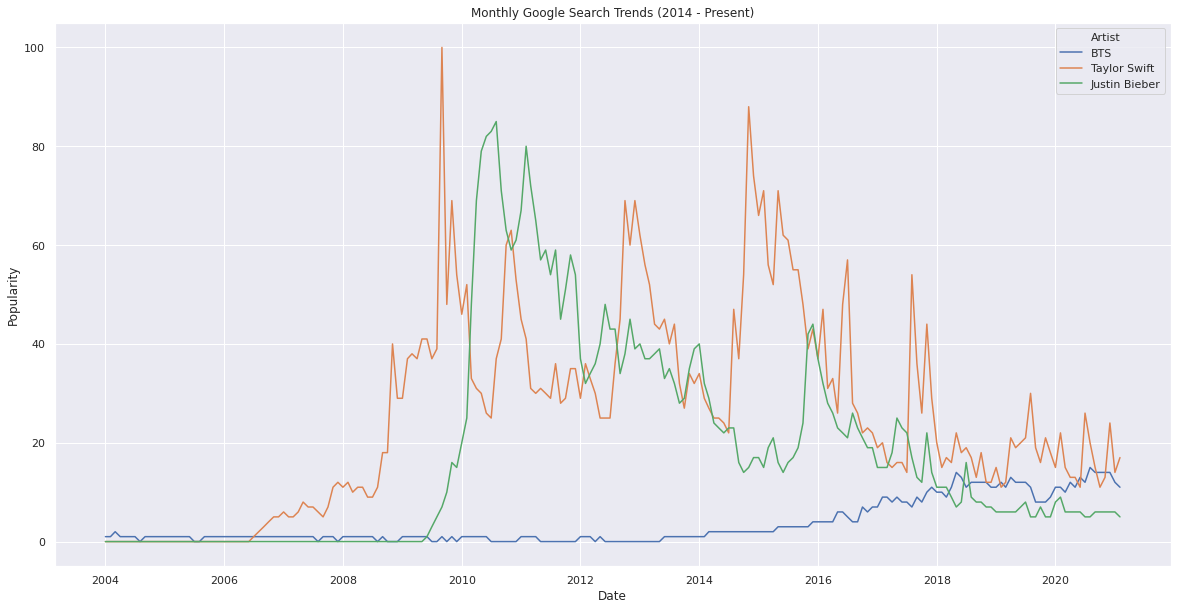

In [15]:
g = sns.lineplot(data = overall_monthly, x = 'date', y = 'Popularity',
                 hue = 'Artist', dashes = False)
g.set_title('Monthly Google Search Trends (2014 - Present)')
g.set(xlabel = 'Date')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff774e6dd50>,
      dtype=object)

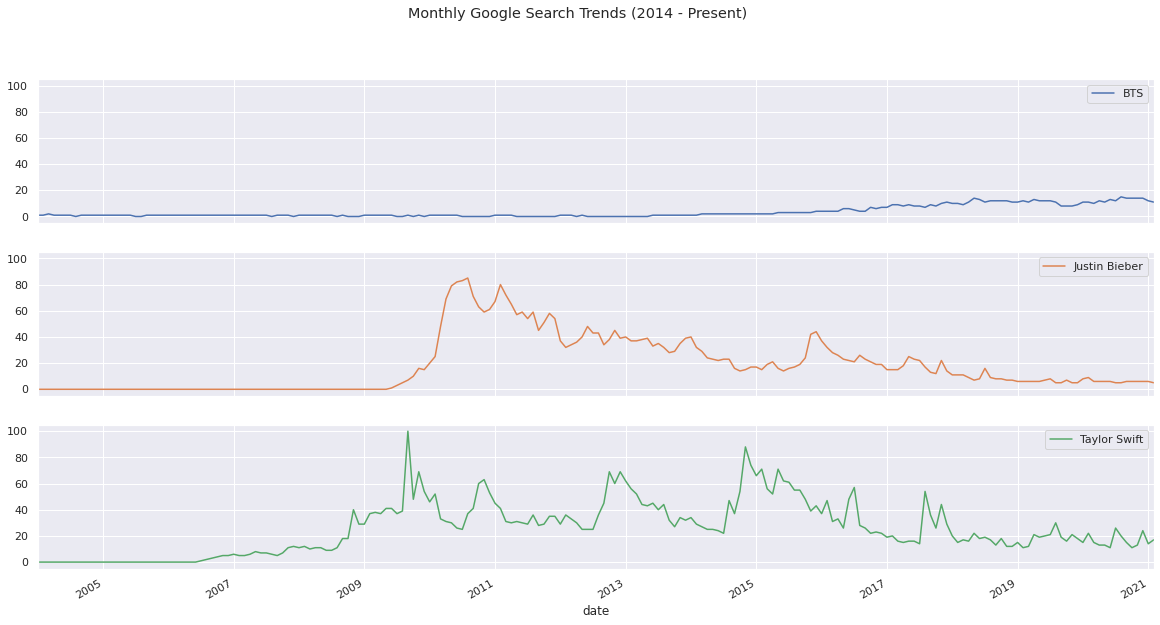

In [16]:
pd.pivot_table(overall_monthly,
               index='date', columns='Artist', values='Popularity'
              ).plot(subplots=True,
                    title = 'Monthly Google Search Trends (2014 - Present)',
                    sharey = True)

### Timeframe Plotting Popularity

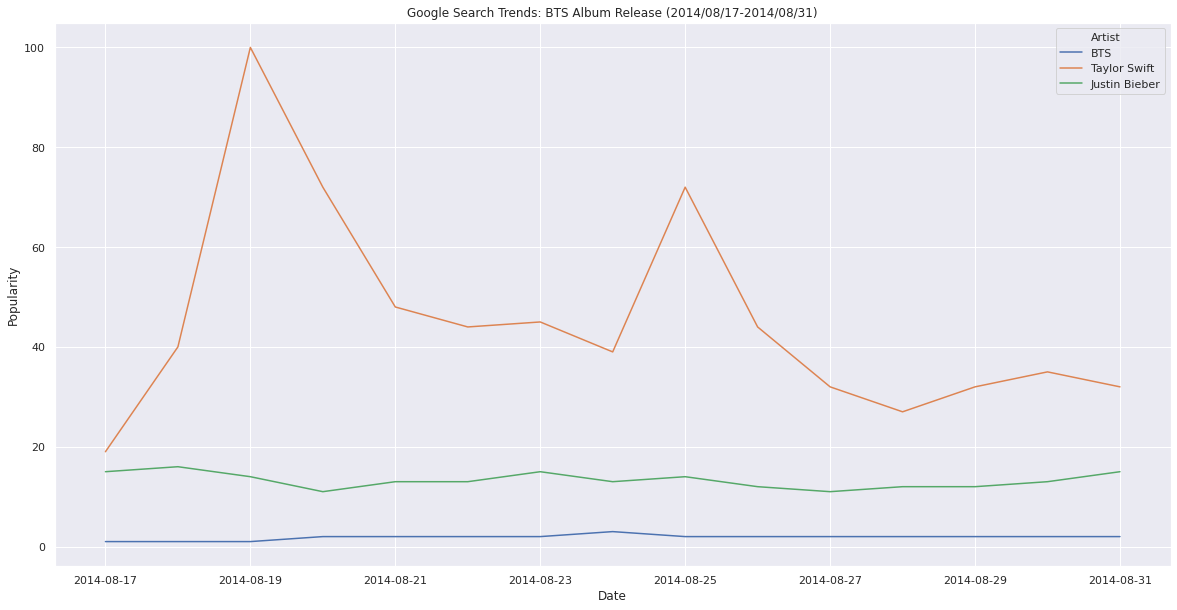

ReadTimeout: HTTPSConnectionPool(host='trends.google.com', port=443): Read timed out. (read timeout=5)

In [26]:
c = 0
df_list = []

for albums in music_timeframes:
    for dates in albums:
        pytrends.build_payload(kw_list = artists, cat = 3, timeframe = dates) 
        
        ranged = pytrends.interest_over_time()

        ranged.drop('isPartial', inplace = True, axis = 1)
        ranged.reset_index(inplace = True)

        ranged = ranged.melt(id_vars = ['date'],
                            var_name = 'Artist',
                            value_name = 'Popularity')
        df_list.append(ranged)
        
        #labels
        
        date_labels = dates.split(' ')
        
        file_name = 'graphs/' + artist_albums[c] + '_' +\
        date_labels[0] + '_' + date_labels[1] +\
        '.png'
        
        date_labels[0] = date_labels[0].replace('-', '/')
        date_labels[1] = date_labels[1].replace('-', '/')
        
        
        
        title_text = 'Google Search Trends: ' + artist_albums[c] +\
        ' Album Release (' + date_labels[0] + '-' + date_labels[1] + ')'
        
        #plotting
        
        g = sns.lineplot(data = ranged, x = 'date', y = 'Popularity',
                 hue = 'Artist', dashes = False)
        
        g.xaxis.set_major_locator(ticker.MaxNLocator(nbins = 8))
        
        g.set_title(title_text)
        g.set(xlabel = 'Date')
        
        plt.savefig(file_name, dpi=300)
        
#         labels = np.arange(-2, 15, 1)
#         ranged.index = labels
        
#         g = ranged.plot(kind = 'line',
#                    title = title_text)
        
#         g.set_xlabel("Days Since Release")
#         g.set_ylabel("Popularity")

        plt.show()
        time.sleep(12)
    c += 1
    time.sleep(6)

In [ ]:
big_df = pd.DataFrame()
big_df['Artist'] = df_list[0]['Artist']

artist_c = 0
timeframe_c = 1

for i in range(len(df_list)):
    if timeframe_c == 4:
        artist_c += 1
        timeframe_c = 1
        
    col = artist_albums[artist_c] + ' album ' + str(timeframe_c)
    
    big_df[col] = df_list[i]['Popularity']
    
    timeframe_c += 1

In [ ]:
a = big_df.loc[big_df['Artist'] == 'BTS']
a['Day'] = np.arange(-2, 15)

In [ ]:
b = a.melt(id_vars = ['Artist', 'Day'],
       var_name = 'Group',
       value_name = 'Popularity')

sns.lineplot(data = b, x = 'Day', y = 'Popularity', hue = 'Group')

## Plotly Plotting - Popularity

### Overall Monthly Popularity

In [ ]:
#plot monthly search popularity for entire time frame available
px.line(overall_monthly, x = 'date', y = 'Popularity', color = 'Artist',
        title = 'Monthly Google Search Trends (2014 - Present)')

In [ ]:
px.area(overall_monthly, x = 'date', y = 'Popularity',
        title = 'Monthly Google Search Trends', facet_col = 'Artist',
       facet_col_wrap = 2)

### Timeframe Plotting Popularity

In [ ]:
c = 0

for albums in music_timeframes:
    for dates in albums:
        pytrends.build_payload(kw_list = artists, cat = 3, timeframe = dates) 
        
        ranged = pytrends.interest_over_time()

        ranged.drop('isPartial', inplace = True, axis = 1)
        ranged.reset_index(inplace = True)

        ranged = ranged.melt(id_vars = ['date'],
                            var_name = 'Artist',
                            value_name = 'Popularity')
        
        #labels
        
        date_labels = dates.split(' ')
        date_labels[0] = date_labels[0].replace('-', '/')
        date_labels[1] = date_labels[1].replace('-', '/')
        
        title_text = 'Google Search Trends: ' + artist_albums[c] +\
        ' Album Release (' + date_labels[0] + '-' + date_labels[1] + ')'
        
        
        title_text = 'Google Search Trends: ' + artist_albums[c] +\
        ' Album Release (' + dates + ')'
        
        fig = px.line(ranged, x = 'date', y = 'Popularity',
                      color = 'Artist', title = title_text)   
        
        fig.show()
        
    c += 1

## Plotly Plotting - Regions

In [ ]:
# px.choropleth(regions_w_code, locations="countryCode",
#               color="Taylor Swift",
#               #hover_name="geoName", # column to add to hover information
#               color_continuous_scale=px.colors.sequential.Plasma)

### Related Searches

Let's find the related queries and topics for each artist during their album releases.

In [ ]:
bts_topics = pd.DataFrame(columns = ['value','topic_title', 'topic_type', 'date'])
bts_queries = pd.DataFrame(columns = ['value','query','date'])

for bts in bts_timeframes:

    pytrends.build_payload(kw_list = ['BTS'], cat = 3, timeframe = bts)

    #topics
    topics = pytrends.related_topics()

    topt = topics['BTS']['top'][['value', 'topic_title', 'topic_type']]
    topt['date'] = album

    bts_topics = pd.concat([bts_topics, topt])
    time.sleep(6)
    
    #queries
    queries = pytrends.related_queries()

    topq = queries['BTS']['top']
    topq['date'] = album

    bts_queries = pd.concat([bts_queries, topq])
    
    time.sleep(6)

In [ ]:
ts_topics = pd.DataFrame(columns = ['value','topic_title', 'topic_type','date'])
ts_queries = pd.DataFrame(columns = ['value','query','date'])

for ts in ts_timeframes:

    pytrends.build_payload(kw_list = ['Taylor Swift'], cat = 3, timeframe = ts)
    
    try:
        #topics
        topics = pytrends.related_topics()

        topt = topics['Taylor Swift']['top'][['value', 'topic_title', 'topic_type']]
        topt['date'] = ts

        ts_topics = pd.concat([ts_topics, topt])
        time.sleep(6)

        #queries
        queries = pytrends.related_queries()

        topq = queries['Taylor Swift']['top']
        topq['date'] = ts

        ts_queries = pd.concat([ts_queries, topq])
        
        time.sleep(6)
    except:
        print('add manually')
        print('date: ', str(ts))
        print('topics?', str(len(topics)))
        print('queries?', str(len(queries)))

In [ ]:
jb_topics = pd.DataFrame(columns = ['value','topic_title', 'topic_type','date'])
jb_queries = pd.DataFrame(columns = ['value','query','date'])

for jb in jb_timeframes:

    pytrends.build_payload(kw_list = ['Justin Bieber'], cat = 3, timeframe = jb)
    
    try:
        #topics
        topics = pytrends.related_topics()

        topt = topics['Justin Bieber']['top'][['value', 'topic_title', 'topic_type']]
        topt['date'] = jb

        jb_topics = pd.concat([jb_topics, topt])
        time.sleep(12)

        #queries
        queries = pytrends.related_queries()

        topq = queries['Justin Bieber']['top']
        topq['date'] = jb

        jb_queries = pd.concat([jb_queries, topq])
        
        time.sleep(12)
    except:
        print('add manually')
        print('date: ', str(jb))
        print('topics?', str(len(topics)))
        print('queries?', str(len(queries)))

In [ ]:
jb_queries